# NetCDF Einführung: Teil 2

## 1. Zugriff auf den Datensatz zur Visualisierung

In [1]:
import os

# ---- Legen Sie unten die Verzeichnisse fest ----
download_folder = r"./era5-land-monthly/download"  # Ordner für heruntergeladene Daten
output_folder = r"./era5-land-monthly/output"      # Ordner für die endgültigen Ausgaben
# ---- Ende der Benutzereingaben ----

# Erstellen Sie die Verzeichnisse, falls sie nicht existieren
os.makedirs(download_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Daten einlesen und untersuchen

In [3]:
# Geben Sie den Dateinamen des Datensatzes an und erstellen Sie den vollständigen Pfad
filename = "reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc"
filepath = os.path.join(download_folder, filename)

# Zeigen Sie den erstellten Dateipfad zur Überprüfung an
print(f"Dateipfad des Datensatzes: {filepath}")

Dateipfad des Datensatzes: ./era5-land-monthly/download\reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc


## 3. Variablen auslesen und grundlegende Metadaten generieren

In [4]:
import netCDF4 as nc

# Öffnen der NetCDF-Datei im Lesemodus
dataset = nc.Dataset(filepath, mode='r')

# Alle Variablen im Datensatz auflisten
variables_list = dataset.variables.keys()
print(f"Verfügbare Variablen: {list(variables_list)}")

# Extrahieren der Koordinatendaten und der Hauptvariablen
lon_list = dataset['longitude'][:]  # Extrahieren der Längengrade
lat_list = dataset['latitude'][:]   # Extrahieren der Breitengrade

Verfügbare Variablen: ['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']


In [5]:
import pandas as pd

test_variable = 't2m'
variable_data = dataset[test_variable]

# Zusammenfassung der Hauptvariablen erstellen
summary = {
    "Variablenname": test_variable,
    "Datentyp": variable_data.dtype,
    "Form": variable_data.shape,
    "Variableninfo": f"{test_variable}({', '.join(variable_data.dimensions)})",
    "Einheiten": getattr(variable_data, "units", "N/A"),
    "Langer Name": getattr(variable_data, "long_name", "N/A"),
}

# Darstellung der Metadaten als DataFrame zur besseren Übersicht
nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])

# Ausgabe des DataFrames
nc_summary

,Beschreibung,Bemerkungen
0,Variablenname,t2m
1,Datentyp,float32
2,Form,"(898, 3, 4)"
3,Variableninfo,"t2m(valid_time, latitude, longitude)"
4,Einheiten,K
5,Langer Name,2 metre temperature


In [6]:
import numpy as np
import pandas as pd

# Pandas-Anzeigeeinstellungen für bessere Lesbarkeit anpassen
pd.set_option('display.max_colwidth', None)

# Zusammenfassung des Datensatzes erstellen
ds_summary = {
    "Institution": dataset.institution if hasattr(dataset, 'institution') else "N/A",
    "Dimensionen": list(dataset.dimensions.keys()),
    "Variablen": list(dataset.variables.keys()),
    "Variablen-Dimensionen": [
        np.shape(dataset[variable]) for variable in dataset.variables.keys()
    ],
}

# Konvertieren der Zusammenfassung in ein DataFrame zur besseren Übersicht
dataset_summary = pd.DataFrame(list(ds_summary.items()), columns=['Beschreibung', 'Bemerkungen'])

# Ausgabe der Zusammenfassung
dataset_summary

,Beschreibung,Bemerkungen
0,Institution,European Centre for Medium-Range Weather Forecasts
1,Dimensionen,"[valid_time, latitude, longitude]"
2,Variablen,"[number, valid_time, latitude, longitude, expver, t2m]"
3,Variablen-Dimensionen,"[(), (898,), (3,), (4,), (898,), (898, 3, 4)]"


## 3. Einfaches Diagramm für August 1980 erstellen

In [7]:
# Definieren des Zieljahres und -monats für die Visualisierung
selected_year = 1980
selected_month = 8

# Berechnung des Bandindex für das ausgewählte Jahr und den Monat
# Der Index wird durch die Position in der Zeitdimension bestimmt
band_index = (selected_year - 1950) * 12 + (selected_month - 1)

# Extrahieren des Datenbereichs für das ausgewählte Jahr und den Monat
# Dies liefert die räumlichen Daten (Breitengrad x Längengrad) für die angegebene Zeit
band_data = variable_data[band_index, :, :]

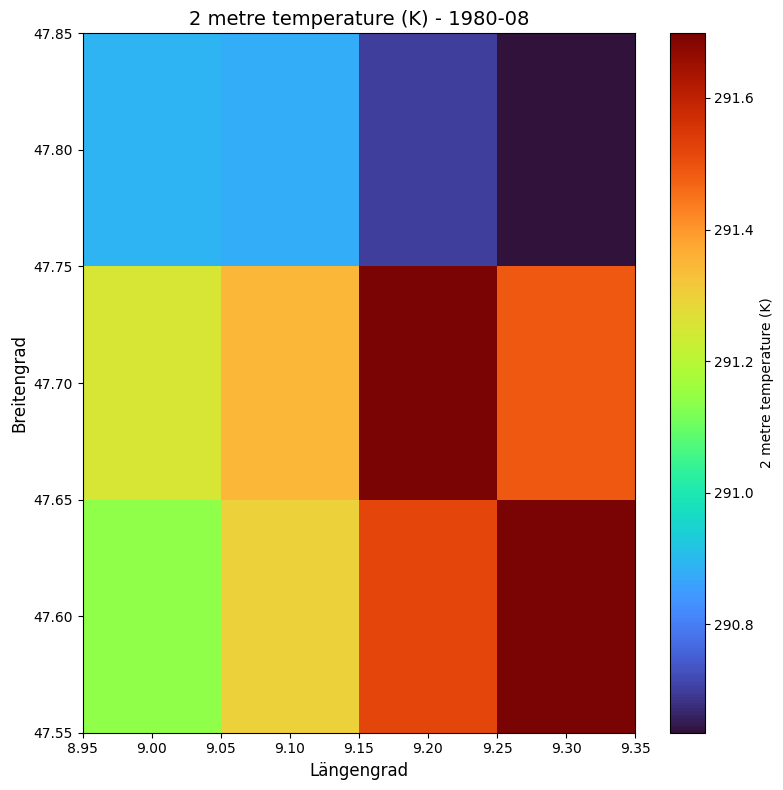

In [8]:
import matplotlib.pyplot as plt

# Diagramm mit Matplotlib erstellen
fig, ax = plt.subplots(figsize=(8, 8))

# Vordefinierte Farbskala laden
cmap = plt.get_cmap("turbo")

# Erstellen eines Pseudo-Farbdiagramms für die Daten
pcm = ax.pcolormesh(
    lon_list,
    lat_list,
    band_data,
    cmap=cmap,
    shading="auto",
)

# Farbskala mit Einheiten hinzufügen
cbar = plt.colorbar(pcm, ax=ax, label=f'{summary["Langer Name"]} ({summary["Einheiten"]})')

# Diagrammtitel und Achsenbeschriftungen setzen
ax.set_title(
    f'{summary["Langer Name"]} ({summary["Einheiten"]}) - {selected_year}-{selected_month:02d}',
    fontsize=14,
)
ax.set_xlabel("Längengrad", fontsize=12)
ax.set_ylabel("Breitengrad", fontsize=12)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

## 4. Erweitertes Diagramm für August 1980 erstellen

In [9]:
import numpy as np
import math as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Umwandlung der Temperaturdaten von Kelvin in °C
band_data_C = variable_data[band_index, :, :] - 273.15

# Berechnung der minimalen und maximalen Werte
vmin = np.nanmin(band_data_C)
vmax = np.nanmax(band_data_C)

vmin_floor = ma.floor(vmin * 10) / 10
vmax_ceil = ma.ceil(vmax * 10) / 10

# Berechnung des Intervalls für die Farbskala
interval = 0.1
bins = int((vmax_ceil - vmin_floor) / interval)

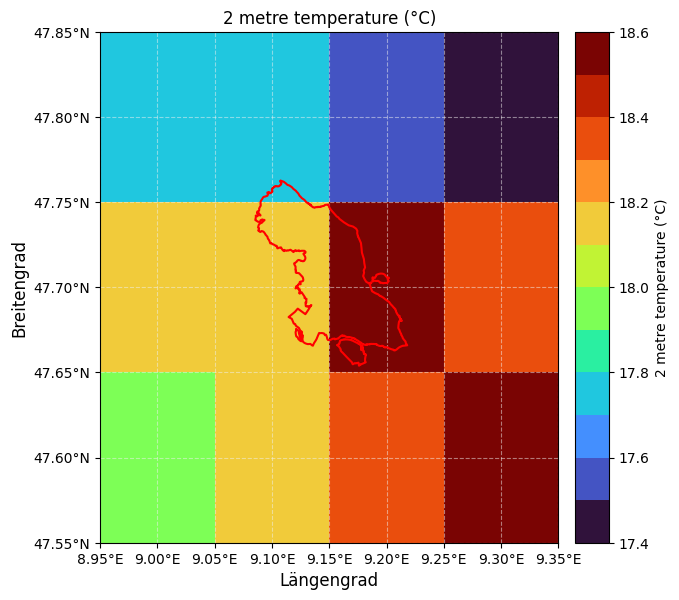

In [10]:
# Funktionen zur Formatierung der Achsenbeschriftungen
def format_latitude(x, pos):
    return f"{x:.2f}°N"

def format_longitude(x, pos):
    return f"{x:.2f}°E"

# Diagramm erstellen
fig, ax = plt.subplots(figsize=(8, 8))

# Farbskala mit 10 diskreten Farben laden
cmap = plt.get_cmap('turbo', bins)

pcm = ax.pcolormesh(
    lon_list,
    lat_list,
    band_data_C,
    cmap=cmap,
    vmin=vmin_floor,
    vmax=vmax_ceil
)

# Verwaltungsgrenze von Konstanz (Shapefile) hinzufügen
konstanz_shp = r"./shapefiles/kn_boundary.shp"
konstanz_boundary = gpd.read_file(konstanz_shp)
konstanz_boundary.boundary.plot(ax=ax, edgecolor='red')

# Farbskala hinzufügen
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)
plt.colorbar(pcm, cax=cax, label=f'{summary["Langer Name"]} (°C)')

# Gitternetzlinien hinzufügen
ax.grid(visible=True, which='major', color='#f0f0f0', linestyle='--', alpha=0.5)

# Benutzerdefinierte Achsenbeschriftungen setzen
ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
ax.yaxis.set_major_formatter(FuncFormatter(format_latitude))

ax.set_title(f'{summary["Langer Name"]} (°C)')
ax.set_ylabel('Breitengrad', fontsize=12)
ax.set_xlabel('Längengrad', fontsize=12)

# Diagramm anzeigen
plt.show()

## 5. Zeitreihendiagramm erstellen

In [11]:
# Listen zur Speicherung der Statistiken initialisieren
mean_values_list = []
median_values_list = []
std_values_list = []

# Gesamtanzahl der Zeitbänder berechnen
total_bands = range(variable_data.shape[0])

# Jahre und Monate aus dem Zeitindex ableiten
year_list = [(band_index // 12) + 1950 for band_index in total_bands]
month_list = [(band_index % 12) + 1 for band_index in total_bands]

# Über alle Zeitbänder iterieren und Statistiken berechnen
for band_index in total_bands:
    band_data = variable_data[band_index, :, :] - 273.15

    mean_values_list.append(np.nanmean(band_data))
    median_values_list.append(np.ma.median(band_data))
    std_values_list.append(np.nanstd(band_data))

# Daten in ein DataFrame umwandeln
df_statistics = pd.DataFrame({'Jahr': year_list, 'Monat': month_list, 'Mittelwert': mean_values_list, 'Median': median_values_list, "Std-Abweichung": std_values_list})

# Anzeige der ersten Zeilen des DataFrames
df_statistics.head()

,Jahr,Monat,Mittelwert,Median,Std-Abweichung
0,1950,1,-1.677588,-1.677588,0.263794
1,1950,2,2.095921,2.076715,0.314301
2,1950,3,4.579808,4.523981,0.255085
3,1950,4,7.100448,7.199243,0.331744
4,1950,5,14.580113,14.644403,0.342235


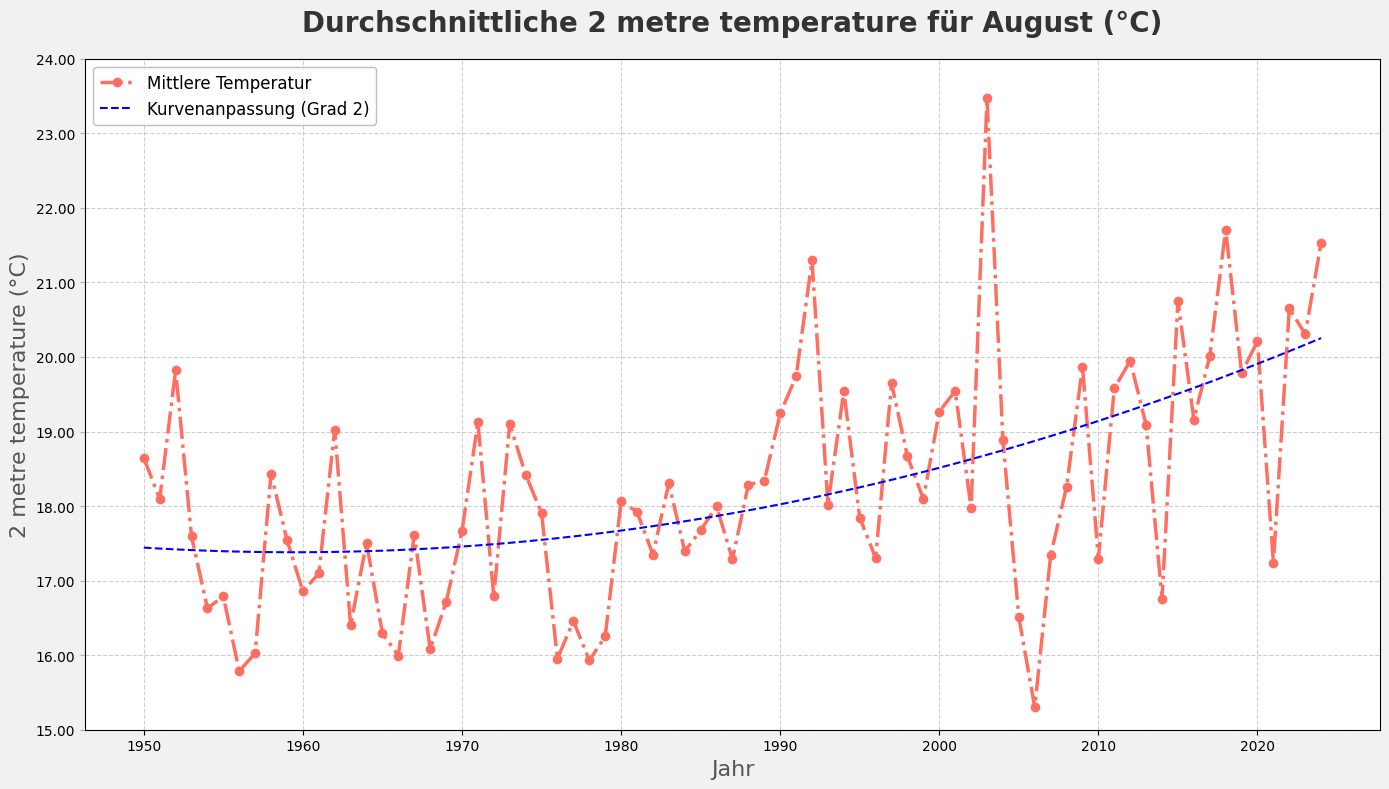

In [13]:
import matplotlib.ticker as ticker

# Filtern des Statistik-DataFrames für den ausgewählten Monat (August)
selected_month = 8  # August
df_statistics_filtered = df_statistics[df_statistics['Monat'] == selected_month]

# Diagramm initialisieren
fig, ax = plt.subplots(figsize=(14, 8), facecolor='#f1f1f1')

# Titel und Achsenbeschriftungen setzen
ax.set_title(
    f'Durchschnittliche {summary["Langer Name"]} für August (°C)',
    fontsize=20,
    fontweight='bold',
    color='#333333',
    pad=20
)
ax.set_xlabel("Jahr", fontsize=16, color='#555555')
ax.set_ylabel(f'{summary["Langer Name"]} (°C)', fontsize=16, color='#555555')

# Diagrammparameter für Konsistenz aktualisieren
params = {
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

# Gitternetz und Tick-Formatierung hinzufügen
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.tick_params(axis='y', which='both', color='#b0b0b0')

# Grenzen der y-Achse definieren
ax.set_ylim(15, 24)

# Durchschnittliche Temperaturtrends darstellen
line1, = ax.plot(
    df_statistics_filtered['Jahr'],
    df_statistics_filtered['Mittelwert'].astype(float),
    label='Mittlere Temperatur',
    color='#ff6f61',
    linestyle='-.',
    marker='o',
    linewidth=2.5
)

# Quadratische Trendlinie (Grad 2) anpassen
degree = 2  # Quadratische Anpassung
coefficients = np.polyfit(
    df_statistics_filtered['Jahr'],
    df_statistics_filtered['Mittelwert'].astype(float),
    degree
)
curve_fit = np.poly1d(coefficients)

# Trendlinie im Diagramm darstellen
ax.plot(
    df_statistics_filtered['Jahr'],
    curve_fit(df_statistics_filtered['Jahr']),
    label=f'Kurvenanpassung (Grad {degree})',
    color='blue',
    linestyle='--',
    linewidth=1.5
)

# Legende hinzufügen
ax.legend(loc='upper left', fontsize=12, frameon=True, facecolor='#ffffff', edgecolor='#b0b0b0')

# Diagramm anzeigen
plt.tight_layout()
plt.show()
